# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from IPython.core.display import display, HTML, clear_output
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate, interpolate
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os


In [4]:
sys.path.append("../")
import plotting as my_plot
import akta

In [10]:
files = os.listdir('./data/')
files = [f for f in files if '2022 06 13' in f]
dfs = {}
for f in files:
    dfs[f] = akta.read_data_normalized(f'./data/{f}', get_tis=False)

In [11]:
files

['CH 2022 06 13 SEC standards ovalbumin 2.xls',
 'CH 2022 06 13 SEC standards gamma globulins 1.xls',
 'CH 2022 06 13 SEC standards ribonuclease A 1.xls']

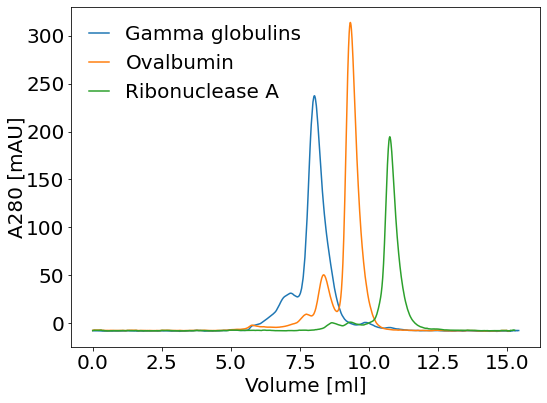

In [13]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

f, name = 'CH 2022 06 13 SEC standards gamma globulins 1.xls', 'Gamma globulins'
ax.plot(dfs[f].volume_ml, dfs[f].uv_280_mAU, label=name)

f, name = 'CH 2022 06 13 SEC standards ovalbumin 2.xls', 'Ovalbumin'
ax.plot(dfs[f].volume_ml, dfs[f].uv_280_mAU, label=name)

f, name = 'CH 2022 06 13 SEC standards ribonuclease A 1.xls', 'Ribonuclease A'
ax.plot(dfs[f].volume_ml, dfs[f].uv_280_mAU, label=name)

my_plot.set_layout(fig, ax, legend=True, loc='upper left')
# plt.savefig('./images/SEC_Stds_Akta_explorer.png', dpi=300, bbox_inches='tight')

In [14]:
for f in files:
    df = dfs[f]
    print(f, '\n', df[df.uv_280_mAU == df.uv_280_mAU.max()], '\n')

CH 2022 06 13 SEC standards ovalbumin 2.xls 
      volume_ml uv_280_mAU uv_254_mAU uv_295_mAU
5183  9.329577    313.896    126.277     74.331 

CH 2022 06 13 SEC standards gamma globulins 1.xls 
      volume_ml uv_280_mAU uv_254_mAU uv_295_mAU
3144  8.029465    237.389     80.636     62.555 

CH 2022 06 13 SEC standards ribonuclease A 1.xls 
       volume_ml uv_280_mAU uv_254_mAU uv_295_mAU
7375  10.760262    194.673     69.218      4.273 



In [15]:
volumes = {
    'ovalbumin':9.329577,
    'gamma globulin':8.029465,
    'ribonuclease a':10.760262
}

In [43]:
df_std_curve = pd.read_csv('./std_curve/sec_column_std_curve.csv')
for i, cont in df_std_curve.iterrows():
    if cont.species in volumes.keys():
        df_std_curve.at[i, 'my_v_ml'] = volumes[cont.species]

df_std_curve['delta_v_ml'] = df_std_curve.my_v_ml - df_std_curve.v_ml
mean_delta = df_std_curve['delta_v_ml'].mean()
df_std_curve['v_akta_ml'] = df_std_curve.v_ml + mean_delta

spline = interpolate.UnivariateSpline(df_std_curve['v_akta_ml'], np.log(df_std_curve['true_mass_da']), k=5)
def get_mass_kDa(v):
    return np.exp(spline(v))*1e-3

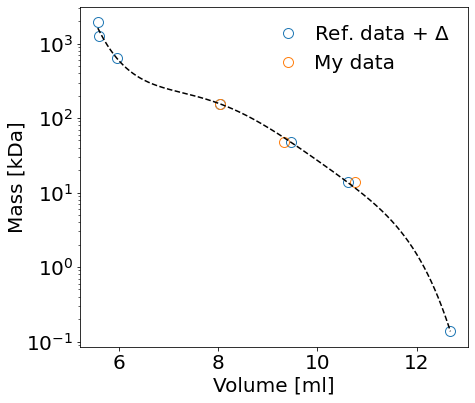

In [44]:
fig, ax = my_plot.instantiate_fig(x=7, y=6, xlabel='Volume [ml]', ylabel='Mass [kDa]')
ax.plot(df_std_curve['v_akta_ml'], df_std_curve['true_mass_da']*1e-3, 'o', fillstyle='none', markersize=10, label=r'Ref. data + $\Delta$')
ax.plot(df_std_curve['my_v_ml'], df_std_curve['true_mass_da']*1e-3, 'o', fillstyle='none', markersize=10, label=r'My data')

v_pts = np.linspace(df_std_curve['v_akta_ml'].min(), df_std_curve['v_akta_ml'].max(), 1000)
m_pts = get_mass_kDa(v_pts)
ax.plot(v_pts, m_pts, 'k--')

ax.set_yscale('log')

my_plot.set_layout(fig, ax, legend=True)
# plt.savefig('./images/SEC_Std_curve.png', dpi=300, bbox_inches='tight')

In [86]:
def forward(v_ml):
    return np.exp(np.interp(v_ml, v_pts, np.log(m_pts)))

def inverse(m_kDa):
    return np.interp(np.log(m_kDa), np.log(m_pts[::-1]), v_pts[::-1])

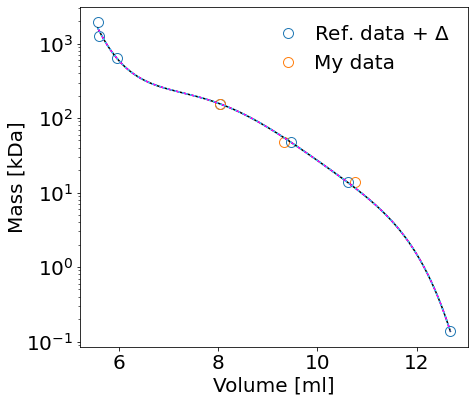

In [87]:
fig, ax = my_plot.instantiate_fig(x=7, y=6, xlabel='Volume [ml]', ylabel='Mass [kDa]')
ax.plot(df_std_curve['v_akta_ml'], df_std_curve['true_mass_da']*1e-3, 'o', fillstyle='none', markersize=10, label=r'Ref. data + $\Delta$')
ax.plot(df_std_curve['my_v_ml'], df_std_curve['true_mass_da']*1e-3, 'o', fillstyle='none', markersize=10, label=r'My data')

v_pts = np.linspace(df_std_curve['v_akta_ml'].min(), df_std_curve['v_akta_ml'].max(), 1000)
m_pts = get_mass_kDa(v_pts)
ax.plot(v_pts, m_pts, 'k')

ax.plot(v_pts, forward(v_pts), '--', color='magenta')
ax.plot(inverse(m_pts), m_pts, ':', color='cyan')

ax.set_yscale('log')
my_plot.set_layout(fig, ax, legend=True)

In [25]:
files = os.listdir('./data/')
files.sort()
files = [f for f in files if '2022 03 05' in f or '2022 03 06' in f]

In [26]:
dfs = {}
for f in files:
    dfs[f] = akta.load_and_clean_xls(f'./data/{f}')

dfs[files[0]]['run'] = 1
dfs[files[0]] = dfs[files[0]][dfs[files[0]]['uv_280_ml'].notna()].copy()
v_max_1 = max(dfs[files[0]].uv_280_ml)

dfs[files[1]].uv_280_ml += v_max_1
dfs[files[1]].fractions_ml += v_max_1
dfs[files[1]].inject_ml += v_max_1
dfs[files[1]] = dfs[files[1]][dfs[files[1]]['uv_280_ml'].notna()].copy()
dfs[files[1]]['run'] = 2

df = pd.concat([dfs[files[0]], dfs[files[1]]], ignore_index=True)

In [28]:
v_inj = df.inject_ml[df.inject_ml.notna()].values
cycle_nums = {}
for i, v in enumerate(v_inj):
    cycle_nums[v] = i
    
cycles = []
for i, cont in df.iterrows():
    v = v_inj[v_inj - cont.uv_280_ml <= 0][-1]
    cycles.append(cycle_nums[v])
df['cycle'] = cycles

offset = 5.0
for i, v in enumerate(v_inj):
    indeces = df[df.cycle==i].index
    vals = df[df.cycle==i].uv_280_ml.values
    df.loc[indeces, 'cycle_ml'] = vals - v

for i, v in enumerate(v_inj):
    indeces = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].index
    vals = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].uv_280_ml.values
    df.loc[indeces, 'cycle_decon'] = i
    df.loc[indeces, 'cycle_decon_ml'] = vals - (v + offset)
    

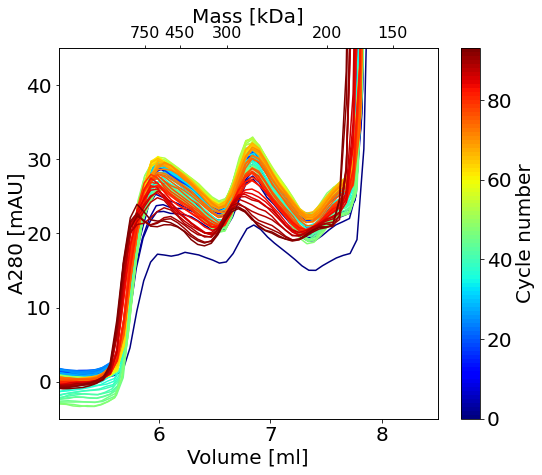

In [119]:
fig, ax = my_plot.instantiate_fig(x=8, y=7, xlabel='Volume [ml]', ylabel='A280 [mAU]')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax)
cbar.set_label('Cycle number')

ax.set_xlim(5.1, 8.5)
ax.set_ylim(-5, 45)
selected_m = [750, 450, 300, 200, 150]

def tick_function(X):
    V = forward(X)
    return ["%.0f" % z for z in V]

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([inverse(m) for m in selected_m])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations), fontsize=16)
ax2.set_xlabel("Mass [kDa]", fontsize=20)

my_plot.set_layout(fig, ax)
plt.savefig('./images/HCCF_optimized_1_overlay_zoomed_with_mass_estimates.png', dpi=300, bbox_inches='tight')

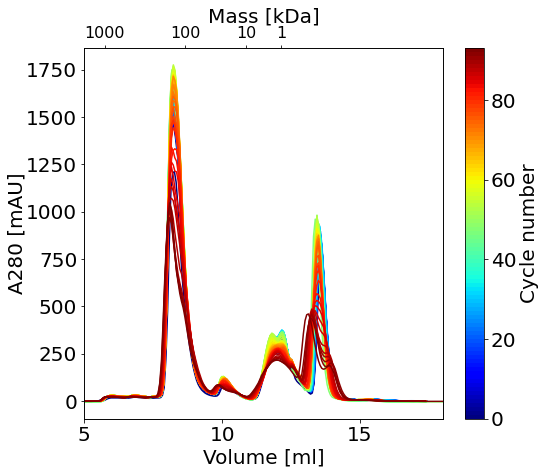

In [144]:
fig, ax = my_plot.instantiate_fig(x=8, y=7, xlabel='Volume [ml]', ylabel='A280 [mAU]')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax)
cbar.set_label('Cycle number')

ax.set_xlim(offset, 18)
# selected_m = [750, 150, 50, 15, 1]
selected_m = [1e3, 1e2, 1e1, 1e0]

def tick_function(X):
    V = forward(X)
    return ["%.0f" % z for z in V]

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([inverse(m) for m in selected_m])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations), fontsize=16)
ax2.set_xlabel("Mass [kDa]", fontsize=20)

my_plot.set_layout(fig, ax)
plt.savefig('./images/HCCF_optimized_1_overlay_with_mass_estimates.png', dpi=300, bbox_inches='tight')

In [22]:
v_all_peaks = []

for i in range(len(v_inj)):
    df_large = df[(df.cycle_decon==i) & (df.cycle_decon_ml + offset <= 6.55)]
    df_small = df[(df.cycle_decon==i) & (df.cycle_decon_ml + offset > 6.55) & (df.cycle_decon_ml + offset <= 7.35)]
    df_mab   = df[(df.cycle_decon==i) & (df.cycle_decon_ml + offset > 7.91) & (df.cycle_decon_ml + offset <= 9.65)]
    df_lmw1  = df[(df.cycle_decon==i) & (df.cycle_decon_ml + offset > 9.65) & (df.cycle_decon_ml + offset <= 11.0)]
    df_lmw2a = df[(df.cycle_decon==i) & (df.cycle_decon_ml + offset > 11.0) & (df.cycle_decon_ml + offset <= 12.0)]
    df_lmw2b = df[(df.cycle_decon==i) & (df.cycle_decon_ml + offset > 12.0) & (df.cycle_decon_ml + offset <= 12.7)]
    df_lmw3  = df[(df.cycle_decon==i) & (df.cycle_decon_ml + offset > 12.7) & (df.cycle_decon_ml + offset <= 14.5)]
    
    v_peaks = [i]
    for df_slice in [df_large, df_small, df_mab, df_lmw1, df_lmw2a, df_lmw2b, df_lmw3]:
        v_peaks.append(df_slice.loc[df_slice.uv_280_mAU == df_slice.uv_280_mAU.max(), 'cycle_decon_ml'].iloc[0] + offset)
    v_all_peaks.append(v_peaks)
    
df_v_peaks = pd.DataFrame(v_all_peaks, columns=['cycle', 'large', 'small', 'mab', 'lmw1', 'lmw2a', 'lmw2b', 'lmw3'])


In [23]:
data = []

for col in ['large', 'small', 'mab', 'lmw1', 'lmw2a', 'lmw2b', 'lmw3']:
    mean_v = df_v_peaks[col].mean()
    mass_kDa = get_mass_kDa(mean_v)
    vals = [col, mean_v, mass_kDa]
    data.append(vals)

df_peak_masses = pd.DataFrame(data, columns=['peak', 'volume_ml', 'mass_kDA'])
df_peak_masses.to_csv('./std_curve/peak_masses.csv')

In [24]:
df_peak_masses

,peak,volume_ml,mass_kDA
0,large,6.001264,592.147453
1,small,6.822843,265.021329
2,mab,8.205919,140.233664
3,lmw1,10.035580,25.887273
4,lmw2a,11.886328,1.938457
5,lmw2b,12.151942,0.978386
6,lmw3,13.476808,0.000447
